<a href="https://www.kaggle.com/code/hydramst/water-pollution-lr?scriptVersionId=97992349" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-pollution/Submission.csv
/kaggle/input/water-pollution/Target.csv
/kaggle/input/water-pollution/Train.csv
/kaggle/input/water-pollution/Test.csv


In [2]:
DF_train = pd.read_csv('/kaggle/input/water-pollution/Train.csv', delimiter = ',')
DF_test = pd.read_csv('/kaggle/input/water-pollution/Test.csv', delimiter = ',')
Target = pd.read_csv('/kaggle/input/water-pollution/Target.csv', delimiter = ',')
Submission = pd.read_csv('/kaggle/input/water-pollution/Submission.csv', delimiter = ',')

# Check if ID's in train presented in train

In [3]:
len(set(DF_train['id'].values).intersection(set(DF_test['id'].values)))/len(set(DF_test['id'].values))

0.6333333333333333

63% of test ID's presented in train

In [4]:
# ID's presented in train and in test

df_id = set(DF_train['id'].values).intersection(set(DF_test['id'].values))
DF_test[DF_test['id'].isin(df_id)]['id']
#DF_test = DF_test[DF_test['id'].isin(df_id)]

0                 FRHR326
3      DERW_DENW2742_0_16
5         SE667320-153747
7                 FRCR333
8                 ES12113
              ...        
116              FRHR216C
117            UKSC010040
118              FRHR216C
119               FRFR201
121               FRDR625
Name: id, Length: 78, dtype: object

### Concatinate train and test

In [5]:
df = pd.concat([DF_train, DF_test])

In [6]:
df = df.drop(columns = ['Unnamed: 0'])

## View categorical and numerical columns

In [7]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

categorical columns:	  ['code', 'period', 'id', 'Country'] 
 len =  4
numerical columns:	  ['year', 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 
 len =  13


## Move 'year' to num columns 

In [8]:
cat_columns = ['code', 'period', 'id', 'Country', 'year']
num_columns = [ 'tourists', 'venue', 'rate', 'food', 'glass', 'metal', 'other', 'paper', 'plastic', 'leather', 'green_waste', 'waste_recycling'] 


## OHE 

In [9]:
df_ohe = pd.get_dummies(df[cat_columns])
df_all = pd.concat([df_ohe, df[num_columns]], axis=1)

# Scaling

In [10]:
# Creating StandardScaler Object
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df_all[num_columns]))
df_all = pd.concat([df_ohe.reset_index(drop=True), df_scale.reset_index(drop=True)], axis=1)

## Split back to test and train 


In [11]:
len_test = len(DF_test)
train = df_all.iloc[:-len_test]
test = df_all.iloc[-len_test:]
print(DF_train.shape[0], train.shape[0], DF_test.shape[0], test.shape[0])

2318 2318 122 122


# Log Scaling 

In [12]:
#target_log = np.log(Target['polution'])
#target_log
target_orig = Target['polution']
len(pd.DataFrame(train))

2318

# Traintest split

In [13]:
X, y = pd.DataFrame(train).values, target_orig.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(1854, 464, 1854, 464)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1854, 1562), (464, 1562), (1854,), (464,))

# GridSearchCV

In [15]:
### define model
model = Ridge()

alphas = np.array([1,0.1,0.01,0.001,0.0001,0.000001, 0.0000001])

# define parameters
param = {
    'alpha':alphas,
    'positive':[True, False],
    'copy_X':[True,False],
    'fit_intercept':[True,False]
    
}
#grid = GridSearchCV(model, param, scoring='r2', cv=2, n_jobs=-1)
#grid.fit(X_train, y_train)
#predictions = grid.predict(X_test)
#print('R2 : %.4f' %  r2_score(y_test,predictions))
#print('R2 : %.4f' % grid.best_score_)

# ElasticNetCV

In [16]:
model_ElasticCV = ElasticNetCV(n_alphas=1, fit_intercept=True, max_iter=100000, l1_ratio=0.9, eps=0.0001, cv=5)

#model_ElasticCV.fit(X_train, y_train)

#y_predict_ElasticCV = model_ElasticCV.predict(X_test)

#print('R2 : %.4f' %  r2_score(y_test,y_predict_ElasticCV))

# ElasticNet

In [17]:
model_Elastic = ElasticNet(alpha=0.00005, fit_intercept=True, max_iter=100000, l1_ratio=0.07)

model_Elastic.fit(X_train, y_train)

y_predict_Elastic = model_Elastic.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict_Elastic))

R2 : 0.4608


# Ridge LR

In [18]:

model = Ridge(alpha = 0.1, fit_intercept=True, max_iter=10000)

model.fit(X_train, y_train)

y_predict=model.predict(X_test)

print('Error on test data:')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Error on test data:
MSE: 0.0
RMSE: 0.1
R2 : 0.4517


# Lasso

In [19]:
model_L = Lasso(alpha=0.00001, fit_intercept=True)

model_L.fit(X_train, y_train)
y_predict=model_L.predict(X_test)

print('R2 : %.4f' %  r2_score(y_test,y_predict))

R2 : 0.4415


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e-01, tolerance: 2.959e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Compare answers with original values

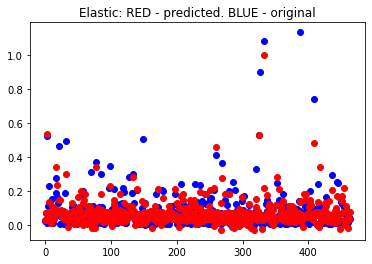

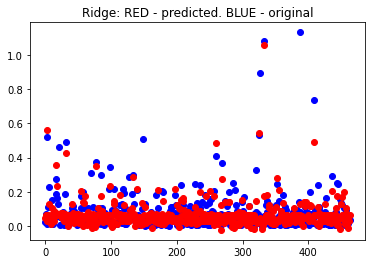

In [20]:
def plotGraph(y_test,y_predict,regressorName):
    if max(y_test) >= max(y_predict):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_predict))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_predict)), y_predict, color='red')
    plt.title(regressorName)
    plt.show()
    return


plotGraph(y_test, y_predict_Elastic, "Elastic: RED - predicted. BLUE - original")
plotGraph(y_test, y_predict, "Ridge: RED - predicted. BLUE - original")

# Cross validation

In [21]:
def cross_val(model, X_train, y_train):
  scoring = {'R2': 'r2',
            '-MSE': 'neg_mean_squared_error',
            '-MAE': 'neg_mean_absolute_error',
            'Max': 'max_error'}


  scores = cross_validate(model, X_train, y_train,
                        scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42) )

  print('CV Results')
  DF_cv_linreg = pd.DataFrame(scores)
  display(DF_cv_linreg)
  print('\n')
  print(DF_cv_linreg.mean()[2:])
  print('\n')

cross_val(model_Elastic, X_train, y_train)

CV Results


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,100.130593,0.008689,0.132610,-0.008197,-0.046149,-0.572531
1,85.158923,0.003175,0.402822,-0.008040,-0.046943,-0.514508
2,104.231195,0.008990,0.513161,-0.004093,-0.041495,-0.251783
3,106.400721,0.018475,0.295109,-0.007791,-0.042216,-0.790434
4,55.099007,0.002707,0.383778,-0.006580,-0.042723,-0.519121




test_R2      0.345496
test_-MSE   -0.006940
test_-MAE   -0.043905
test_Max    -0.529675
dtype: float64




In [22]:
model = Ridge(alpha=0.0001, max_iter=10000)

model.fit(X_train, y_train)

y_predict = model_Elastic.predict(test)

#y_predict = np.exp(y_predict)
Submission['polution'] = y_predict
Submission

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,idx,polution
0,402,0.074855
1,748,0.072251
2,763,0.078516
3,942,0.100101
4,1258,0.036633
...,...,...
117,19447,0.238138
118,19458,0.098328
119,19464,0.036322
120,19699,0.069361


In [23]:
! rm /kaggle/working/water-pollution/Submission.csv
! mkdir /kaggle/working/water-pollution/
Submission['polution'][27] = 2.0

rm: cannot remove '/kaggle/working/water-pollution/Submission.csv': No such file or directory


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
Submission.to_csv('/kaggle/working/water-pollution/Submission.csv',index=False)

In [25]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"hydramst","key": "" }' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [26]:
cat ~/.kaggle/kaggle.json

{"username":"hydramst","key": "" }


In [27]:
#! kaggle competitions submit -f /kaggle/working/water-pollution/Submission.csv -m "Message" sf-matml-2022-regression